# Histogram-based Gradient Boosting Classification Tree

Libraries and data.

In [117]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Data
X_train_df = pd.read_csv('../data/gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('../data/gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

Data split.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

Cross-validation.

In [119]:
# Set up the MultiOutputClassifier with Random Forest Regressor
multi_output_clf = MultiOutputClassifier(HistGradientBoostingClassifier(random_state=42))

In [120]:
# # Let's do GridSearchCV
# # parameters grid
# param_grid = {
#     "estimator__learning_rate" : [0.05, 0.1, 0.2, 0.3],
#     "estimator__max_iter" : [100, 200, 300],
#     "estimator__max_leaf_nodes" : [31, 63, 127],
#     "estimator__max_depth" : [None, 5, 10, 20, 30],
#     "estimator__min_samples_leaf" : [20, 50, 100],
# }

In [121]:
# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=multi_output_clf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters from Grid Search:", grid_search.best_params_)
# print("Best Score from Grid Search:", grid_search.best_score_)

# # Evaluate on the test set
# y_pred_grid = grid_search.predict(X_test)
# mse_grid = mean_squared_error(y_test, y_pred_grid)
# acc_grid = accuracy_score(y_test, y_pred_grid)
# print(f"Mean Squared Error (Grid Search): {mse_grid}")
# print(f"Accuracy (Grid Search): {acc_grid}")

Best hyperparameters.

In [122]:
estimators = MultiOutputClassifier(
    estimator = HistGradientBoostingClassifier(
        learning_rate = 0.05, 
        max_depth = 5,
        max_iter = 200,
        max_leaf_nodes = 31,
        min_samples_leaf = 100
    )
)


The model is trained to study performance.

In [123]:
estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=HistGradientBoostingClassifier(learning_rate=0.05,
                                                               max_depth=5,
                                                               max_iter=200,
                                                               min_samples_leaf=100))

Predictions.

In [124]:
preds = estimators.predict_proba(X_test)
preds

[array([[0.98546632, 0.01453368],
        [0.59361749, 0.40638251],
        [0.94413765, 0.05586235],
        ...,
        [0.97562337, 0.02437663],
        [0.62210794, 0.37789206],
        [0.7132895 , 0.2867105 ]]),
 array([[0.70212372, 0.29787628],
        [0.23628104, 0.76371896],
        [0.91146678, 0.08853322],
        ...,
        [0.89067088, 0.10932912],
        [0.35813233, 0.64186767],
        [0.50095623, 0.49904377]])]

A dataframe is created with the predictions.

In [125]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.014534,0.297876
1215,0.406383,0.763719
10540,0.055862,0.088533
7407,0.177417,0.298124
14697,0.119161,0.195681


### **RESULTS: ROC CURVE**

ROC curve to evaluate the model.

In [126]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

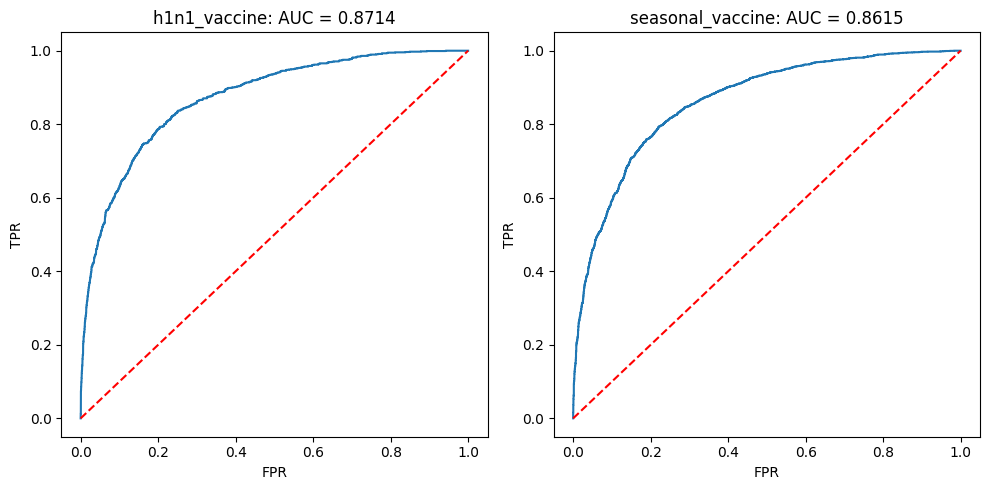

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

// EXPLICAR LOS RESULTADOS DE LA ROC CURVE

### **RESULTS: CONFUSION MATRIX**

Confusion matrix.

In [128]:
preds_no_proba = estimators.predict(X_test)
preds

[array([[0.98546632, 0.01453368],
        [0.59361749, 0.40638251],
        [0.94413765, 0.05586235],
        ...,
        [0.97562337, 0.02437663],
        [0.62210794, 0.37789206],
        [0.7132895 , 0.2867105 ]]),
 array([[0.70212372, 0.29787628],
        [0.23628104, 0.76371896],
        [0.91146678, 0.08853322],
        ...,
        [0.89067088, 0.10932912],
        [0.35813233, 0.64186767],
        [0.50095623, 0.49904377]])]

In [129]:
y_preds_no_proba = pd.DataFrame(
    {
        'h1n1_vaccine': preds_no_proba[:, 0],
        'seasonal_vaccine': preds_no_proba[:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds_no_proba.shape)
y_preds_no_proba.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0,0
1215,0,1
10540,0,0
7407,0,0
14697,0,0


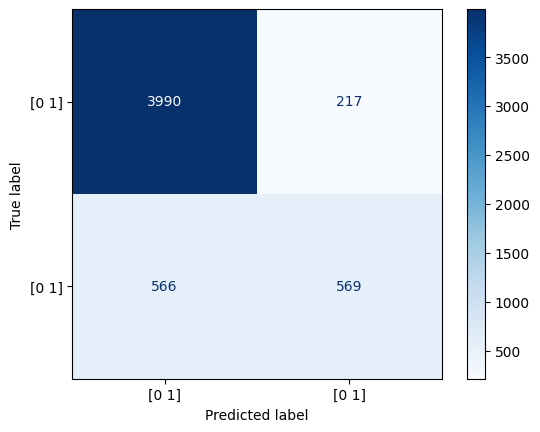

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4207
           1       0.72      0.50      0.59      1135

    accuracy                           0.85      5342
   macro avg       0.80      0.72      0.75      5342
weighted avg       0.84      0.85      0.84      5342



In [131]:
# h1n1_vaccine
cm = metrics.confusion_matrix(y_test['h1n1_vaccine'], y_preds_no_proba['h1n1_vaccine'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test['h1n1_vaccine'], y_preds_no_proba['h1n1_vaccine']))

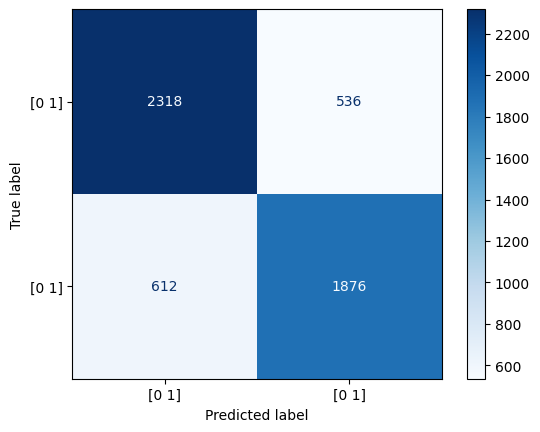

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2854
           1       0.78      0.75      0.77      2488

    accuracy                           0.79      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.79      0.78      5342



In [132]:
cm = metrics.confusion_matrix(y_test['seasonal_vaccine'], y_preds_no_proba['seasonal_vaccine'])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(y_test['seasonal_vaccine'], y_preds_no_proba['seasonal_vaccine']))

### **FIT AND PREDICT RESULTS FOR COMPETITION UPLOAD**

The model is trained for the competition.

In [ ]:
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)
preds

[array([[0.82554712, 0.17445288],
        [0.96966466, 0.03033534],
        [0.82090183, 0.17909817],
        ...,
        [0.79252543, 0.20747457],
        [0.97591585, 0.02408415],
        [0.41776785, 0.58223215]]),
 array([[0.8044585 , 0.1955415 ],
        [0.97322294, 0.02677706],
        [0.27090889, 0.72909111],
        ...,
        [0.80673297, 0.19326703],
        [0.6486015 , 0.3513985 ],
        [0.2997355 , 0.7002645 ]])]

A dataframe is created with the predictions.

In [100]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.174453,0.195542
26708,0.030335,0.026777
26709,0.179098,0.729091
26710,0.660595,0.885527
26711,0.255183,0.492735


Export the CSV.

In [101]:
y_preds.to_csv('../results/pred_hist_gradient_boosting.csv', index = True)